In [2]:
import sys
import os

notebook_directory = os.getcwd()
sys.path.append(
    os.path.abspath(
        os.path.join(os.path.dirname(notebook_directory), '../..')
    )
)

from pbh_explorer.telescopes.fermi_lat.weekly import WeeklyDataAnalysis
from pbh_explorer.observations.ObsSnapFermiLAT import ObsSnapFermiLAT
from pbh_explorer.objects import AstroObject
from pbh_explorer.analysis import ObsOnOff

In [14]:
weekly = WeeklyDataAnalysis()
dataset = weekly.get_map_dataset(map_type="hpx")
bkg_map = dataset.background
dataset.background = None
fermi_obs_snap = ObsSnapFermiLAT(dataset)
pbh = AstroObject.PrimordialBlackHole.generate_random_pbh()

The input MapDataset is based on <class 'gammapy.maps.hpx.ndmap.HpxNDMap'>.


Hawking radiation already calculated, skipping.


In [15]:
import copy
obs_on = copy.deepcopy(fermi_obs_snap)
obs_off = copy.deepcopy(fermi_obs_snap)

In [16]:
def add_signal_models(
    obs,
    signal_models=None,
):
    """
    +-- Map RoI --------------+
    |                         |
    |        Count RoI        |
    |      ###       ###      |
    |    ##             ##    |
    |   ##      * <- BH  ##   |
    |    ##             ##    |
    |      ###       ###      |
    |         #######         |
    |                         |
    +-------------------------+
    
    Returns:
        masked map: しきい値より小さいピクセルをマスクしたマップ
    """
    if not signal_models:
        from gammapy.modeling.models import (
            Models,
            PointSpatialModel,
            PowerLawSpectralModel,
            SkyModel,
        )
        spatial_model = PointSpatialModel(lon_0="0 deg", lat_0="0 deg", frame="galactic")
        spectral_model = PowerLawSpectralModel(
            index=2.7, amplitude="5.8e-10 cm-2 s-1 TeV-1", reference="100 GeV"
        )

        source = SkyModel(
            spectral_model=spectral_model,
            spatial_model=spatial_model,
            name="source-gc",
        )
        signal_models = Models([source])
    
    if not obs.map_dataset.models:
        org_dataset_sig_models = Models([])
    else:
        org_dataset_sig_models = Models([])
        for sky_model in obs.map_dataset.models[:]:
            org_dataset_sig_models.append(sky_model)
    
    obs.map_dataset.models = org_dataset_sig_models + signal_models
    print(obs.map_dataset)
    return obs


In [28]:
obs_on = add_signal_models(obs_on)
obs_on.map_dataset.background = bkg_map
print(obs_on.map_dataset)

Model source-gc is outside the target geom but contributes inside through the psf.This contribution cannot be estimated precisely.Consider extending the dataset geom and/or the masked margin in the mask_fit.
Convolution via WCS projection is not recommended for large maps (> 10 deg). Perhaps the method `convolve_full()` is more suited for this case.


MapDataset
----------

  Name                            : VUxsZtK4 

  Total counts                    : 220623 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 1126.45
  Predicted background counts     : nan
  Predicted excess counts         : 1126.45

  Exposure min                    : 5.73e+07 cm2 s
  Exposure max                    : 1.50e+09 cm2 s

  Number of total bins            : 196608 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 23108583.44

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : source-gc
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      index             

In [23]:
print(obs_off.map_dataset)

MapDataset
----------

  Name                            : VUxsZtK4 

  Total counts                    : 220623 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.73e+07 cm2 s
  Exposure max                    : 1.50e+09 cm2 s

  Number of total bins            : 196608 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [44]:
for i in obs_on.map_dataset.models:
    print(i.spatial_model)

PointSpatialModel

type  name   value    unit   error      min        max    frozen link prior
---- ----- ---------- ---- --------- ---------- --------- ------ ---- -----
     lon_0 0.0000e+00  deg 0.000e+00        nan       nan  False           
     lat_0 0.0000e+00  deg 0.000e+00 -9.000e+01 9.000e+01  False           


In [57]:
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion

lon = obs_on.map_dataset.models[0].spatial_model.lon_0.quantity
lat = obs_on.map_dataset.models[0].spatial_model.lat_0.quantity
frame = obs_on.map_dataset.models[0].spatial_model.frame


on_region_spectra = []
# SkyCoord に変換
on_region = \
                CircleSkyRegion(
                    center=SkyCoord(lon, lat, frame=frame),
                    radius=Angle("1 deg")
                )
on_region_spectra.append(
                obs_on.map_dataset.to_spectrum_dataset(on_region)
            )

AttributeError: 'SkyCoord' object has no attribute 'ra'

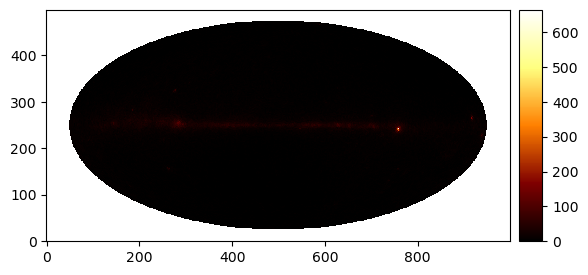

In [61]:
import matplotlib.pyplot as plt
from gammapy.maps import WcsNDMap
from astropy.coordinates import SkyCoord

# 仮の MapDataset を作成（実際は読み込んだり解析の結果を使用）
map_dataset = obs_on.map_dataset

# モデルの位置を取得
positions = []
for model in map_dataset.models:
    if hasattr(model, "spatial_model") and model.spatial_model is not None:
        spatial_model = model.spatial_model
        lon = spatial_model.lon_0.quantity
        lat = spatial_model.lat_0.quantity
        frame = getattr(spatial_model, "frame", "icrs")
        coord = SkyCoord(lon, lat, frame=frame)
        positions.append(coord)

# ベースマップの準備（例: MapDataset の背景マップ）
geom = map_dataset.counts.geom  # Map のジオメトリを取得
background_map = map_dataset.background
wcs_map = WcsNDMap.from_geom(geom, data=background_map.data)

# プロット
fig, ax = plt.subplots(subplot_kw={"projection": wcs_map.geom.wcs})
wcs_map.plot(ax=ax, add_cbar=True)

# モデルの位置をプロット
for coord in positions:
    ax.scatter(coord.ra.deg, coord.dec.deg, transform=ax.get_transform("icrs"), color="red", label="Model Position")

plt.legend()
plt.show()


In [3]:
pbh.create_time_window_average_models()

In [ ]:
pbh.

In [4]:
from astropy.time import Time
from astropy import units as u
distance=0.1*u.pc
tstart="2000-01-01"
tstop="2010-01-01"
particle_list=["photon"]

In [5]:
time_interval = Time(tstop) - Time(tstart)
time_interval.sec

315619202.0

In [6]:
pbh_initial_lifetime = Time(pbh.state_history["evaporated_time"][0]) - Time(tstart)
pbh_initial_lifetime

<TimeDelta object: scale='tai' format='jd' value=356.03732697916666>

In [7]:
Time(tstart)

<Time object: scale='utc' format='iso' value=2000-01-01 00:00:00.000>

In [8]:
if Time(tstart)+pbh_initial_lifetime < Time(tstart):
    print('a')
else:
    print('b')

b


In [9]:
if Time(tstart)+pbh_initial_lifetime < Time(tstart):
    pass
else:
    str_idx = pbh.hawking_radiation._dts['rt'][
                pbh.hawking_radiation._dts['rt'] >= pbh_initial_lifetime
            ].argmin()
    
    if pbh.hawking_radiation._dts['rt'][str_idx] == pbh_initial_lifetime:
        time_factor = 0
    else:
        excess_time = pbh.hawking_radiation._dts['rt'][str_idx] - (pbh_initial_lifetime.sec * u.s)
        time_step = pbh.hawking_radiation._dts['rt'][str_idx] - pbh.hawking_radiation._dts['rt'][str_idx+1]
        time_factor = (time_step - excess_time) / time_step

In [10]:
time_factor

<Quantity 0.52868261>

In [11]:
import numpy as np

In [12]:
# particleごとのスペクトルモデルの作成
for i, particle in enumerate(['photon']):

    # primary成分とsecondary成分ごとにエネルギーとフラックスを抽出
    component_energy_array = {}
    component_spectra_array = {}
    for component in ["primary","secondary"]:
        spectra_table = \
            pbh.hawking_radiation.integral_radiation_spectra[f"{particle}_{component}"][str_idx:]
        
        energy_bins = np.array([
            u.Quantity(colname).to(u.GeV).value for colname in spectra_table.colnames[1:]
        ]) * u.GeV
        component_energy_array[component] = energy_bins
        
        spectra_list = []
        for colname in spectra_table.colnames[1:]:
            #TODO:合ってるか確認
            # Convert from 1/(GeV cm3) to count number/GeV
            # 最初の行（str_idx）の値にはtime_factorをかける
            col_zeroed = (spectra_table[colname][0] * time_factor * u.cm**3).to(u.GeV**(-1)).value
            # 最初の行を除外して合計
            col_after_zeroed = np.sum((spectra_table[colname][1:] * u.cm**3).to(u.GeV**(-1)).value)
            
            spectra_list.append(
                (col_zeroed + col_after_zeroed)
            )
        component_spectra_array[component] = np.array(spectra_list).T * u.GeV**(-1)

In [17]:
np.shape(component_spectra_array['primary'])

(599,)

In [18]:
np.shape(component_energy_array['primary'])

(599,)

In [14]:
time_interval.sec

315619202.0